# **Tutorial on Object detection**

In this tutorial we will implement some of the steps required to build a two-stage object detection system following the [Faster-RCNN ](http://papers.nips.cc/paper/5638-faster-r-cnn-towards-real-time-object-detection-with-region-proposal-networks)framework (Ren, Shaoqing, et al. "Faster r-cnn: Towards real-time object detection with region proposal networks." Advances in neural information processing systems. 2015.).

<img src="https://docs.google.com/uc?export=download&id=1Uw3SCTw_81eJbHFCCrMwCJCYC-EWlsMW" style="width:500px;height:250px;">
<caption><center> <b>Schematic of a general Faster RCNN architecture.</b> Source: https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4<br> </center></caption>



The code base for these exercises is relying on the [MM-Detect](https://github.com/open-mmlab/mmdetection) toolbox. (Chen, Kai, et al. "MMDetection: Open mmlab detection toolbox and benchmark." arXiv preprint arXiv:1906.07155 (2019).)

In this setting, we will apply what we have learnt regarding two-stage object detection schemes for the detection of white matter lesions using the training data used for lecture 5. We will first mount the google drive and download the data as in lecture 5.


<img src="https://docs.google.com/uc?export=download&id=1eN8lKId0SvJ8Z-DKDHo5coN8iZCTI2gX" style="width:500px;height:250px;">
<caption><center> <b>First step: Import libraries</b><br> </center></caption>

In [ ]:
!pip install torchio

import glob
import re
import sys
import random
import os
import time
import numpy as np
import nibabel as nib
from tqdm import tqdm

# TorchIO read, preprocess, sample, augment, and write 3D medical images. https://github.com/fepegar/torchio
import torchio
from torchio import Image, Subject
from torch.utils.data import DataLoader

# Deep Learning library
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Torchvision consists of popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop

from PIL import Image as impil
from PIL import ImageDraw as imdraw
from matplotlib import pyplot as plt 
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from scipy.ndimage.measurements import label 

# The device used can be changed by clicking on Runtime - Change runtime type - GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
file_download_link = "https://github.com/KCL-BMEIS/AdvancedMachineLearningCourse/blob/main/Week8_Object_Detection/Data/data.tar?raw=true"
!wget -O data.tar --no-check-certificate "$file_download_link"

# Decompress files
!tar -xf data.tar

file_download_link = "https://github.com/KCL-BMEIS/AdvancedMachineLearningCourse/blob/main/Week8_Object_Detection/Data/models.tar?raw=true"
!wget -O models.tar --no-check-certificate "$file_download_link"

# Decompress files
!tar -xf models.tar


We define below the function we need to get our training set and prepare it for future use and initialize the weights of our network(s).



In [ ]:
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c
    ) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

def getiosubjects(path_dir):
    subjects_list = sorted_aphanumeric(os.listdir(path_dir + '/flair/'))
    subjects_list = [s for s in subjects_list if s[0:2] != "._"] # We need to get rid of these files
    iosubjects = []
    for slices in subjects_list:
        subject = torchio.Subject(
          flair=torchio.ScalarImage(path_dir + '/flair/' + slices),
          label=torchio.LabelMap(path_dir + '/labels/wmh' +  slices.split('FLAIR')[1])
        )
        iosubjects.append(subject)

    return iosubjects

from functools import partial

def multi_apply(func, *args, **kwargs):
    pfunc = partial(func, **kwargs) if kwargs else func
    map_results = map(pfunc, *args)
    return tuple(map(list, zip(*map_results)))

def freeze_model(model):
    model.eval()
    for params in model.parameters():
        params.requires_grad = False


def unfreeze_model(model):
    model.train()
    for params in model.parameters():
        params.requires_grad = True 

def unmap(data, count, inds, fill=0):
    """ Unmap a subset of item (data) back to the original set of items (of
    size count) """
    if data.dim() == 1:
        ret = data.new_full((count,), fill)
        ret[inds] = data
    else:
        new_size = (count,) + data.size()[1:]
        ret = data.new_full(new_size, fill)
        ret[inds, :] = data
    return ret

path = ''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_dir ='data' 
training_subjects = getiosubjects(training_dir)

# Training Sets
dataset_training = torchio.SubjectsDataset(training_subjects)

training_loader = DataLoader(dataset_training, shuffle=True, batch_size=6)

def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


The module "torchio.ImagesDataset" can read through DICOM or Nifti Images and returns a dictionary when you call method "getitem". That dictionary contains the different modalities or labels passed when you create the Dataset (i.e., 'FLAIR', 'T1', 'label') as keys, and each item of that dictionary is another dictionary with, at least:
- 'data': torch.tensor with the image itself
- 'affine': affine transformation of the Nifti or DICOM Image
- 'path': path to the image
- 'type': whether it is a label or an intensity image. 

In [ ]:
# If you want to explore the fields of what torchio.ImagesDataset returns, do:
item = dataset_training.__getitem__(0)

print("Each item contains... ", item.keys(), '\n')

print("And if you go to each of the elements..." , '\n')

print("...you've got the image...")
print(item['flair']['data'], '\n')

print("...you've got the type: ", item['flair']['type'], '\n')

print("...you've got the affine transformation...")
print(item['flair']['affine'], '\n')

print("... and you've got the path:", item['flair']['path'], '\n')


# **Part 1 - Defining ground truth boxes and generating anchors** 



<img src="https://docs.google.com/uc?export=download&id=1A0VrdkcOSoJrZK16GtUwfsrrX_JoiV9E" style="width:500px;height:250px;">
<caption><center> <b>Creating bounding boxes based on the segmentations</b><br> </center></caption>

## **Defining GT boxes**
 The first step consists in defining the boxes to detect from the ground truth segmentation. A box is defined by its top left corner (min_x, min_y) and its bottom right corner (max_x, max_y). In the following snippet, complete `create_gt_from_labels` function so that the function has two outputs: the flattened list of ground truth bounding boxes (shape is #gt_boxes, 5) as a torch tensor where the first index indicates the image to which the box corresponds to and a list of tensor (one tensor for each image in the batch)

 The function `plot_boxes_image` will be used in the following to plot the different boxes on the image studied.

In [ ]:
def create_gt_from_labels(batch_labels):
  # batch_labels should be a list containing our labels. 
    list_gtbbox_full = []
    list_gtflat = []
    for (i, gtseg) in enumerate(batch_labels):
        # Hint: shape of gtseg: C x H x W (channel, height, width), so 1 x 128 x 128.
        # Hint: for a certain binary segmentation map, the function 'label'  imported
        # above returns a segmentation map with a different number assigned to each 
        # separate structure (here, lesion) found on the map. It also returns the number
        # of structures.  
        temp_label, numb_lab = label(np.squeeze(gtseg)) # We need squeeze because label needs a HxW image,not a 1xHxW. 
        list_gtbbox = []
        for lab in range(1, numb_lab + 1): # Loop along different lesions
            seg_temp = (temp_label == lab) # We each of the lesions
            indices = np.asarray(np.where(seg_temp == 1)).T # We get all the coordinates of these pixels
            mins = np.min(indices, axis=0) # Minimum height and width
            maxs = np.max(indices, 0) # Maximum height and width
            corners = list(mins) + list(maxs) # [Hmin, Wmin, Hmax, Wmax]
            list_gtbbox.append(corners)
            list_gtflat.append(list((i,)) + list(mins) + list(maxs)) # [BOX_INDEX, Hmin, Wmin, Hmax, Wmax]
        list_gtbbox_full.append(torch.from_numpy(np.asarray(list_gtbbox)))
    return torch.from_numpy(np.asarray(list_gtflat)), list_gtbbox_full


def plot_boxes_image(batch_images, batch_labels, boxes=None, seg_backbone=None,scores=None): 
    """
    This function plots the ground boxes corresponding to the batches presented. 
    Additional boxes can be presented along with the backbone output and or the scores for the proposed boxes
    """
    gtflat, gtfull = create_gt_from_labels(batch_labels)
    list_seg = []
    list_rect = []
    cmap = cm.get_cmap('YlOrRd', 100)
    cmap_values = cmap(np.linspace(0, 1, 100))
    
    if boxes is not None:
        if scores is None:
            for (gtlist, bblist, image, label) in zip(gtfull, boxes, batch_images, batch_labels):
                transfo = image.numpy()
                transfo = (transfo - np.min(transfo))/(np.max(transfo)- np.min(transfo)) * 255
                transfo = np.squeeze(transfo.astype('uint8')).T
                transfo = np.tile(np.expand_dims(transfo, -1), [1,1,3])
                im = impil.fromarray(transfo)
                im_seg = impil.fromarray(transfo)
                draw = imdraw.Draw(im)
                draw_seg = imdraw.Draw(im_seg)
                for (i,bbox) in enumerate(gtlist):
                    # print(bbox)
                    bbox_draw = ((bbox[0], bbox[1]), (bbox[2], bbox[3]))
                    draw_seg.rectangle(bbox_draw, fill=None, outline='#00CCCC')
                for (i,bbox) in enumerate(bblist):
                    # print(bbox)
                    bbox_draw = ((bbox[0], bbox[1]), (bbox[2], bbox[3]))
                    value_color = 'red'
                    draw.rectangle(bbox_draw, fill=None, outline=value_color)
                list_seg.append(im_seg)
                list_rect.append(im)
        if scores is not None:
            for (gtlist, bblist, image, label, score) in zip(gtfull, boxes, batch_images, batch_labels, scores):
                transfo = image.numpy()
                transfo = (transfo - np.min(transfo))/(np.max(transfo)- np.min(transfo)) * 255
                transfo = np.squeeze(transfo.astype('uint8')).T
                transfo = np.tile(np.expand_dims(transfo, -1), [1,1,3])
                im = impil.fromarray(transfo)
                im_seg = impil.fromarray(transfo)
                draw = imdraw.Draw(im)
                draw_seg = imdraw.Draw(im_seg)
                for (i,bbox) in enumerate(gtlist):
                    # print(bbox)
                    bbox_draw = ((bbox[0], bbox[1]), (bbox[2], bbox[3]))
                    draw_seg.rectangle(bbox_draw, fill=None, outline='#00CCCC')
                for (i,bbox) in enumerate(bblist):
                    # print(bbox)
                    bbox_draw = ((bbox[0], bbox[1]), (bbox[2], bbox[3]))
                    value_score = score[i]
                    map_cmap = np.maximum(np.round((value_score - 0.5) * 200),0)
                    map_cmap = np.maximum(np.minimum(map_cmap, 99),0)
                    value_color = cmap_values[int(map_cmap),:-1] * 255
                    draw.rectangle(bbox_draw, fill=None, outline=tuple(value_color.astype(int)))
                list_seg.append(im_seg)
                list_rect.append(im)
                    
    else:
        for (gtlist, image, label) in zip(gtfull, batch_images, batch_labels):
            transfo = image.numpy()
            transfo = (transfo - np.min(transfo))/(np.max(transfo)- np.min(transfo)) * 255
            transfo = np.squeeze(transfo.astype('uint8')).T
            transfo = np.tile(np.expand_dims(transfo, -1), [1,1,3])
            im = impil.fromarray(transfo)
            im_seg = impil.fromarray(np.squeeze(label.numpy()*255).T)
            draw = imdraw.Draw(im)
            for bbox in gtlist:
                # print(bbox)
                bbox_draw = ((bbox[0], bbox[1]), (bbox[2], bbox[3]))
                draw.rectangle(bbox_draw, fill=None, outline='red')
            
            list_seg.append(im_seg)
            list_rect.append(im)
    fig2 = plt.figure(figsize=(20,10))
    if seg_backbone is None:
        spec2 = GridSpec(ncols=len(gtfull), nrows=2, figure=fig2)
        for i in range(len(list_rect)):
            f2_ax1 = fig2.add_subplot(spec2[0, i])
            f2_ax1.imshow(list_rect[i])
            f2_ax2 = fig2.add_subplot(spec2[1,i])
            f2_ax2.imshow(list_seg[i])
    else:
        seg_back = seg_backbone.detach().numpy()
        seg_back = np.squeeze(seg_back)
        spec2 = GridSpec(ncols=len(gtfull), nrows=3, figure=fig2)
        for i in range(len(list_rect)):
            f2_ax1 = fig2.add_subplot(spec2[0, i])
            f2_ax1.imshow(list_rect[i])
            f2_ax2 = fig2.add_subplot(spec2[1,i])
            f2_ax2.imshow(list_seg[i])
            f2_ax3 = fig2.add_subplot(spec2[2, i])
            f2_ax3.imshow(seg_back[i,:,:].T)
        
    plt.show()


Let us test out if we can produce the appropriate boxes for the ground truth

In [ ]:
# Select a batch in our training set
patch_s = iter(training_loader).next()

# Define our images and associated ground truth
batch_images = patch_s['flair']['data'][..., 0]
batch_labels = patch_s['label']['data'][..., 0]
# plot our images with associated ground truth label
plot_boxes_image(batch_images, batch_labels)


## **Generating anchors**

Now that we have defined our ground truth, we need to define the generation of anchors that will be used by the region proposal network (RPN).

At a given location, multiple anchors are possible. They are characterised by their basic size, their scale (multiplicator of the basic size), their ratios (ratio between width and height).

The class AnchorGenerator allows you to create bounding boxes associated to the different anchors according to these parameters. First we create using `gen_base_anchors` the 9 types of anchors that will then be defined at each cell location of the feature map (via the `grid_anchors` function)

In addition to the characteristics of the anchors, the stride parameter indicates the space in between center locations at the image level. This is chosen as the scale reduction between the image map and the feature map.



In [ ]:
# Definition of the anchors
class AnchorGenerator(object):


    def __init__(self, base_size, scales, ratios):
        self.base_size = base_size # 2-element tuple or list
        self.scales = torch.Tensor(scales)
        self.ratios = torch.Tensor(ratios)
        self.base_anchors = self.gen_base_anchors()

    @property
    def num_base_anchors(self):
        return self.base_anchors.size(0)

    def gen_base_anchors(self):
        # Generate the different types of anchors for a given generic location
        # Hint: have a look at the Worked example in the slides
        # Hint: the coordinates will be relative for now, and then will be applied
        # to specific locations (coordinates x,y in the image.)
        w = self.base_size[0]
        h = self.base_size[1]
        x_ctr = 0.5 * (w - 1)
        y_ctr = 0.5 * (h - 1)
        h_ratios = torch.sqrt(self.ratios) # h/ w
        w_ratios = 1 / h_ratios
        ws = (w * w_ratios[:, None] * self.scales[None, :]).view(-1)
        hs = (h * h_ratios[:, None] * self.scales[None, :]).view(-1)
        
        base_anchors = torch.stack(
            [
                x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1),
                x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)
            ],
            dim=-1).round()

            # Combinations of ratios and anchors
        return base_anchors

    def _meshgrid(self, x, y):
        xx = x.repeat(len(y))
        yy = y.view(-1, 1).repeat(1, len(x)).view(-1)
        return xx, yy

    def _meshgrid2(self, x, y):
        yy = y.repeat(len(x))
        xx = x.view(-1, 1).repeat(1, len(y)).view(-1)
        return xx, yy

    def grid_anchors(self, featmap_size, stride=1):

        base_anchors = self.base_anchors
        feat_h, feat_w = featmap_size # Careful here: Y is the ROW, X is the COLUMN. 
        shift_x = torch.arange(0, feat_w) * stride # Coordinates in the row dimension.
        shift_y = torch.arange(0, feat_h) * stride # Coordinates in the column dimension. 

        shift_xx, shift_yy = self._meshgrid2(shift_x, shift_y)

        # Now, you will use one grid of these to define each coordinate of the anchor box.
        shifts = torch.stack([shift_xx, shift_yy, shift_xx, shift_yy], dim=-1)
        shifts = shifts.type_as(base_anchors)

        # Dimension recap:
        # Our shifts are of Kx4 dimensions, where K is the number of different coordinates possible in the feature map.
        #   The first feat_w elements correspond to the first row of shifts. 
        # Anchors are of dimensions Ax4, where A is the number of possible anchors per point.
        # Now, we want to merge A and K to obtain all combination of anchors or shifted anchors (dimension [K, A, 4]), 
        # and then reshape that to have dimensions (KxA, 4), that is, a list of anchors, where the anchors is defined
        # by its 4 coordinates. 

        all_anchors = base_anchors[None, :, :] + shifts[:, None, :] # None adds one dimension. base_anchors was 9 x 4, and like that it's _, 9 x 4.
        all_anchors = all_anchors.view(-1, 4) # We combine all the shifts and boxes combinations on a flat vector. 
        # first A rows correspond to A anchors of (0, 0) in feature map,
        # then (0, 1), (0, 2), ...
        return all_anchors

    def valid_flags(self, featmap_size, valid_size, device=device):
        # Based on valid_size, returns a 1s and 0s grid with 1s whenever we
        # are in a region where valid_size fits the feature map and 0s out of it. 
        feat_h, feat_w = featmap_size
        valid_h, valid_w = valid_size
        assert valid_h <= feat_h and valid_w <= feat_w
        valid_x = torch.zeros(feat_w).type(torch.BoolTensor)
        valid_y = torch.zeros(feat_h).type(torch.BoolTensor)
        valid_x[:valid_w] = 1
        valid_y[:valid_h] = 1
        valid_xx, valid_yy = self._meshgrid2(valid_x, valid_y)
        valid = valid_xx & valid_yy
        valid = valid[:,
                None].expand(valid.size(0),
                             self.num_base_anchors).contiguous().view(-1)
        return valid



def anchor_inside_flags(flat_anchors,
                        valid_flags,
                        img_shape,
                        allowed_border=0, mask=None):
    # We return the valid anchors that are fit within a mask (img_shape. )
    img_h, img_w = img_shape[:2]
    flat_anchors = flat_anchors.type(torch.LongTensor)
    valid_flags = valid_flags.type(torch.BoolTensor)
    if allowed_border >= 0:
        inside_flags = valid_flags & \
                       (flat_anchors[:, 0] >= -allowed_border).type(
                           torch.BoolTensor) & \
                       (flat_anchors[:, 1] >= -allowed_border).type(
                           torch.BoolTensor) & \
                       (flat_anchors[:, 2] < img_w + allowed_border).type(
                           torch.BoolTensor) & \
                       (flat_anchors[:, 3] < img_h + allowed_border).type(
                           torch.BoolTensor)
    else:
        inside_flags = valid_flags
    if mask is not None:
        valid_mask = mask.view(-1).repeat_interleave(int(flat_anchors.shape[0]/(
            mask.shape[-2]*mask.shape[-1])))
        inside_flags *= valid_mask.type(torch.BoolTensor)
    return inside_flags


Let us visualise where the anchors lay and what they look like. First complete the function the `find_anchors_from_index` function that provide the list of indices for the anchors at a given location provided as x,y coordinates.

Try then to display on the given data and play with the different parameters

In [ ]:
# Plot associated anchors for a given index on img
def find_anchors_from_index(x,y,img_shape=[128,128], num_anchors=9):
    # This function returns the indices of the anchors associated to a certain
    # set of coordinates (x,y) in the feature map. 
    # Remember that our anchors list has dimensions: (AxK)x4:
    # ---- every A elements of the list, we change (X,Y) point in the feature map.
    anchors_begin = (x * img_shape[1] + y)* num_anchors
    return np.arange(anchors_begin, anchors_begin + num_anchors)

def plot_anchors_index(img, idx, size=(3,3), scales=(0.5,1,2), ratios=(0.5,1,2)):
    # Plot achors associated to a certain index (X, Y)
    img = np.squeeze(img)
    anchors_gen = AnchorGenerator((3,3),[0.5,1,2],[0.5,1,2])
    anchors_full = anchors_gen.grid_anchors(img.shape, stride=1)
    anchors_indices = find_anchors_from_index(idx[0], idx[1], img.shape, 9)
    anchors_select = anchors_full[anchors_indices,:]
    transfo = (img-np.min(img))/(np.max(img)-np.min(img))*255
    transfo = transfo.astype('uint8').T
    transfo = np.tile(np.expand_dims(transfo,-1),[1,1,3])
    img_pil = impil.fromarray(transfo)
    list_img = []
    fig2 = plt.figure(figsize=(14,14))
    spec2 = GridSpec(3, 3, figure=fig2)
    for (i,f) in enumerate(anchors_select):
        img_pil = impil.fromarray(transfo)
        draw = imdraw.Draw(img_pil)
        draw.rectangle(((f[0],f[1]),(f[2],f[3])),fill=None,outline='#00CCCC',width=1)
        print(f)
        f2_ax1 = fig2.add_subplot(spec2[round(i//3), i%3])
        f2_ax1.imshow(img_pil)


flair_nii = nib.load('data/flair/FLAIR_2_slice_18.nii.gz')
data  = flair_nii.get_data()
plot_anchors_index(data, [50,70])

# **Part 2 - Defining overlap and assigning boxes and proposals**

As of now, we are able to define boxes based from our segmentation and we can generate possible anchors across the image. The next step consists in building the necessary functionalities so as to be able to match ground truth boxes and proposed anchors.

To do so we first need to define measures of overlap and in particular the intersection over union.

Complete the function `bbox_overlaps` that takes as argument the ground_truth boxes and the proposed anchors and returns the matrix of corresponding IoU measures

<img src="https://docs.google.com/uc?export=download&id=1Gne5ugceIT4RKzFbWYMw_2i8lTrCW-HX" style="width:500px;height:250px;">
<caption><center> <b>Defining Intersection over Union (IoU) function</b><br> </center></caption>


<img src="https://docs.google.com/uc?export=download&id=1JBzGka2h76Qy9v9S175mRxbPNf1CI_jO" style="width:500px;height:250px;">
<caption><center> <b>Intersection over Union (IoU) example</b><br> </center></caption>






In [ ]:
def bbox_overlaps(bboxes1, bboxes2, mode='iou'):
    """Calculate overlap between two set of bboxes.

    Args:
        bboxes1 (Tensor): shape (m, 4) in <x1, y1, x2, y2> format.
        bboxes2 (Tensor): shape (n, 4) in <x1, y1, x2, y2> format.
        mode (str): "iou" (intersection over union) or iof (intersection over
            foreground).

    Returns:
        ious(Tensor): shape (m, n) """

    assert mode in ['iou', 'iof']
    bboxes1 = bboxes1.type(torch.LongTensor)
    bboxes2 = bboxes2.type(torch.LongTensor)
    rows = bboxes1.size(0) 
    cols = bboxes2.size(0)
    if rows * cols == 0:
        return bboxes1.new(rows, cols)

    else:
        # Take the minimums and maximums of each of boxes being compared.
        # The :2 takes coordinates 0 and 1 from the 4, so the upper-left corner coordinates (lt: less than)
        # The 2: does the opposite, so it takes those from the lower right corner (the furthest)

        lt = torch.max(bboxes1[:, None, :2], bboxes2[:, :2])  # [rows, cols, 2] # The None adds an additional dimension. 
        rb = torch.min(bboxes1[:, None, 2:], bboxes2[:, 2:])  # [rows, cols, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, cols, 2]
        overlap = wh[:, :, 0] * wh[:, :, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
                bboxes1[:, 3] - bboxes1[:, 1] + 1)
        overlap = overlap.type(torch.FloatTensor)
        area1 = area1.type(torch.FloatTensor)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                    bboxes2[:, 3] - bboxes2[:, 1] + 1)
            area2 = area2.type(torch.FloatTensor)
            ious = overlap / (area1[:, None] + area2 - overlap)

        else:
            ious = overlap / (area1[:, None])

    return ious

In [ ]:
# Example of IOU 
box_1 = torch.tensor([[4, 10, 12, 18], [40, 30, 62, 38]])
box_2 = torch.tensor([[5, 16, 9, 20], [55, 24, 60, 35]])
box_3 = torch.tensor([[5, 9, 11, 17],[41, 30, 65, 35]])
print("Box 1 and 2 = ", bbox_overlaps(box_1, box_2, mode = 'iou'))
print("Box 1 and 3 = ",  bbox_overlaps(box_1, box_3, mode = 'iou'))

We can calculate the IoU between two set of boxes. Complete the required blanks in the `MaxIoUAssigner` class following the assignment algorithm presented in the lecture. 

The idea behind the following block of code is that for N bounding boxes (proposals) and M ground truths, you will assign the best proposals among the N bounding boxes to the M ground truths.
You will do this with these two classes:
 
1.   AssignResult, which contains the final resulting overlaps, and the ground truth indices (from 1 to M) assigned to each of the (1 to N) boxes etc.
2.   MaxIoUAssigner, which will return an object of the class AssignResult by computing the overlaps of the boxes with the ground truths using assign_wrt_overlaps.

*Notice that you assign a ground truth if the IoU goes above a certain threshold. What if there are bounding boxes that don't match any ground truth? they will be assigned 0 (background). The label -1 will be considered as a "don't care" label.*



<img src="https://docs.google.com/uc?export=download&id=17xXgo1fCyfPnn0VRLhPu-T90fDF3QTlV" style="width:500px;height:250px;">
<caption><center> <b>Non-Max suppression example</b> Source: https://www.kdnuggets.com/2018/09/object-detection-image-classification-yolo.html <br> </center></caption>


Read and fill the function. If you need to understand some of the structures that the function assign_wrt_overlaps returns, refer to the picture below the code.


In [ ]:
class AssignResult():
    """
    Stores assignments between predicted and truth boxes.

    Attributes:
        num_gts (int): the number of truth boxes considered when computing this
            assignment

        gt_inds (LongTensor): for each predicted box indicates the 1-based
            index of the assigned truth box. 0 means unassigned and -1 means
            ignore.

        max_overlaps (FloatTensor): the iou between the predicted box and its
            assigned truth box.

        labels (None | LongTensor): If specified, for each predicted box
            indicates the category label of the assigned truth box."""


    def __init__(self, num_gts, gt_inds, max_overlaps, labels=None):
        self.num_gts = num_gts
        self.gt_inds = gt_inds
        self.max_overlaps = max_overlaps
        self.labels = labels

class MaxIoUAssigner():
    """Assign a corresponding gt bbox or background to each bbox.

    Each proposals will be assigned with `-1`, `0`, or a positive integer
    indicating the ground truth index.

    - -1: don't care
    - 0: negative sample, no assigned gt
    - positive integer: positive sample, index (1-based) of assigned gt

    Args:
        pos_iou_thr (float): IoU threshold for positive bboxes.
        neg_iou_thr (float or tuple): IoU threshold for negative bboxes.
        min_pos_iou (float): Minimum iou for a bbox to be considered as a
            positive bbox. Positive samples can have smaller IoU than
            pos_iou_thr due to the 4th step (assign max IoU sample to each gt).
        gt_max_assign_all (bool): Whether to assign all bboxes with the same
            highest overlap with some gt to that gt.
        ignore_iof_thr (float): IoF threshold for ignoring bboxes (if
            `gt_bboxes_ignore` is specified). Negative values mean not
            ignoring any bboxes.
        ignore_wrt_candidates (bool): Whether to compute the iof between
            `bboxes` and `gt_bboxes_ignore`, or the contrary.
        gpu_assign_thr (int): The upper bound of the number of GT for GPU
            assign. When the number of gt is above this threshold, will assign
            on CPU device. Negative values mean not assign on CPU.
    """

    def __init__(self,
                 pos_iou_thr,
                 neg_iou_thr,
                 min_pos_iou=.0,
                 gt_max_assign_all=True,
                 ignore_iof_thr=-1,
                 ignore_wrt_candidates=True,
                 gpu_assign_thr=-1):
        self.pos_iou_thr = pos_iou_thr
        self.neg_iou_thr = neg_iou_thr
        self.min_pos_iou = min_pos_iou
        self.gt_max_assign_all = gt_max_assign_all
        self.ignore_iof_thr = ignore_iof_thr
        self.ignore_wrt_candidates = ignore_wrt_candidates
        self.gpu_assign_thr = gpu_assign_thr

    def assign(self, bboxes, gt_bboxes, gt_bboxes_ignore=None, gt_labels=None):
        """Assign gt to bboxes.

        This method assign a gt bbox to every bbox (proposal/anchor), each bbox
        will be assigned with -1, 0, or a positive number. -1 means don't care,
        0 means negative sample, positive number is the index (1-based) of
        assigned gt.
        The assignment is done in following steps, the order matters.

        1. assign every bbox to -1
        2. assign proposals whose iou with all gts < neg_iou_thr to 0
        3. for each bbox, if the iou with its nearest gt >= pos_iou_thr,
           assign it to that bbox
        4. for each gt bbox, assign its nearest proposals (may be more than
           one) to itself

        Args:
            bboxes (Tensor): Bounding boxes to be assigned, shape(n, 4).
            gt_bboxes (Tensor): Groundtruth boxes, shape (k, 4).
            gt_bboxes_ignore (Tensor, optional): Ground truth bboxes that are
                labelled as `ignored`, e.g., crowd boxes in COCO.
            gt_labels (Tensor, optional): Label of gt_bboxes, shape (k, ).

        Returns:
            :obj:`AssignResult`: The assign result.
        """

        bboxes = bboxes[:, :4].type(torch.IntTensor) # :4 is just in case we've got more than the coordinates. 
        overlaps = bbox_overlaps(gt_bboxes, bboxes)

        # Some bounding boxes are ignored (GT bboxes that contain labels we aren't interested in. )
        if (self.ignore_iof_thr > 0) and (gt_bboxes_ignore is not None) and (
                gt_bboxes_ignore.numel() > 0):
            if self.ignore_wrt_candidates:
                ignore_overlaps = bbox_overlaps(
                    bboxes, gt_bboxes_ignore, mode='iof')
                ignore_max_overlaps, _ = ignore_overlaps.max(dim=1)
            else:
                ignore_overlaps = bbox_overlaps(
                    gt_bboxes_ignore, bboxes, mode='iof')
                ignore_max_overlaps, _ = ignore_overlaps.max(dim=0)
            overlaps[:, ignore_max_overlaps > self.ignore_iof_thr] = -1

        assign_result = self.assign_wrt_overlaps(overlaps, gt_labels)
        return assign_result

    def assign_wrt_overlaps(self, overlaps, gt_labels=None):
        """Assign w.r.t. the overlaps of bboxes with gts.

        Args:
            overlaps (Tensor): Overlaps between k gt_bboxes and n bboxes,
                shape(k, n).
            gt_labels (Tensor, optional): Labels of k gt_bboxes, shape (k, ).

        Returns:
            :obj:`AssignResult`: The assign result.
        """
        num_gts, num_bboxes = overlaps.size(0), overlaps.size(1)

        # 1. assign -1 by default
        # Function new_full: https://www.kite.com/python/docs/torch.Tensor.new_full esentially returns a tensor of size (arg1) filled with value (arg2)
        assigned_gt_inds = overlaps.new_full((num_bboxes,),
                                             -1,
                                             dtype=torch.long)

        if num_gts == 0 or num_bboxes == 0:
            # No ground truth or boxes, return empty assignment
            max_overlaps = overlaps.new_zeros((num_bboxes,))
            if num_gts == 0:
                # No truth, assign everything to background
                assigned_gt_inds[:] = 0
            if gt_labels is None:
                assigned_labels = None
            else:
                assigned_labels = overlaps.new_zeros((num_bboxes,),
                                                     dtype=torch.long)
            return AssignResult(
                num_gts,
                assigned_gt_inds,
                max_overlaps,
                labels=assigned_labels)

        # for each anchor, which gt best overlaps with it
        # for each anchor, the max iou of all gts
        max_overlaps, argmax_overlaps = overlaps.max(dim=0)
        # for each gt, which anchor best overlaps with it
        # for each gt, the max iou of all proposals
        gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)

        # 2. assign negative: below
        if isinstance(self.neg_iou_thr, float):
            # Overlaps that do not match neg_iou_thr (meaning that its overlap with any ground truth is insufficient to match)
            assigned_gt_inds[(max_overlaps >= 0)
                             & (max_overlaps < self.neg_iou_thr)] = 0
        elif isinstance(self.neg_iou_thr, tuple):
          # This is in case you consider your background to be corresponding to two overlaps thresholds (i.e. 0.1 - 0.4 overlap: = background)
            assert len(self.neg_iou_thr) == 2
            assigned_gt_inds[(max_overlaps >= self.neg_iou_thr[0])
                             & (max_overlaps < self.neg_iou_thr[1])] = 0

        # 3. assign positive: above positive IoU threshold
        pos_inds = max_overlaps >= self.pos_iou_thr
        assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1

        # 4. assign fg: for each gt, proposals with highest IoU
        for i in range(num_gts):
            if gt_max_overlaps[i] >= self.min_pos_iou:
                if self.gt_max_assign_all:
                    max_iou_inds = overlaps[i, :] == gt_max_overlaps[i]
                    assigned_gt_inds[max_iou_inds] = i + 1
                else:
                    assigned_gt_inds[gt_argmax_overlaps[i]] = i + 1

        if gt_labels is not None:
            assigned_labels = assigned_gt_inds.new_zeros((num_bboxes,))
            pos_inds = torch.nonzero(assigned_gt_inds > 0).squeeze()
            if pos_inds.numel() > 0:
                assigned_labels[pos_inds] = gt_labels[
                    assigned_gt_inds[pos_inds] - 1]
        else:
            assigned_labels = None
        # return num_gts, assigned_gt_inds, max_overlaps, assigned_labels
        return AssignResult(
            num_gts, assigned_gt_inds, max_overlaps, labels=assigned_labels)


<img src="https://docs.google.com/uc?export=download&id=1Q-yTmsPe9ZemDYbkN32MvKibIdtUs28K" style="width:500px;height:250px;">
<caption><center> <br> </center></caption>

The following functions and classes are useful for you to sample randomly among your positive and negative samples. Indicate as a comment at which stage this may become useful.

In [ ]:
def ensure_rng(rng=None):
    """
    Simple version of the ``kwarray.ensure_rng``

    Args:
        rng (int | numpy.random.RandomState | None):
            if None, then defaults to the global rng. Otherwise this can be an
            integer or a RandomState class
    Returns:
        (numpy.random.RandomState) : rng -
            a numpy random number generator

    References:
        https://gitlab.kitware.com/computer-vision/kwarray/blob/master/kwarray/util_random.py#L270
    """

    if rng is None:
        rng = np.random.mtrand._rand
    elif isinstance(rng, int):
        rng = np.random.RandomState(rng)
    else:
        rng = rng
    return rng


def random_boxes(num=1, scale=1, rng=None):
    """
    Simple version of ``kwimage.Boxes.random``

    Returns:
        Tensor: shape (n, 4) in x1, y1, x2, y2 format.

    References:
        https://gitlab.kitware.com/computer-vision/kwimage/blob/master/kwimage/structs/boxes.py#L1390

    Example:
        >>> num = 3
        >>> scale = 512
        >>> rng = 0
        >>> boxes = random_boxes(num, scale, rng)
        >>> print(boxes)
        tensor([[280.9925, 278.9802, 308.6148, 366.1769],
                [216.9113, 330.6978, 224.0446, 456.5878],
                [405.3632, 196.3221, 493.3953, 270.7942]])
    """
    rng = ensure_rng(rng)

    tlbr = rng.rand(num, 4).astype(np.float32)

    tl_x = np.minimum(tlbr[:, 0], tlbr[:, 2])
    tl_y = np.minimum(tlbr[:, 1], tlbr[:, 3])
    br_x = np.maximum(tlbr[:, 0], tlbr[:, 2])
    br_y = np.maximum(tlbr[:, 1], tlbr[:, 3])

    tlbr[:, 0] = tl_x * scale
    tlbr[:, 1] = tl_y * scale
    tlbr[:, 2] = br_x * scale
    tlbr[:, 3] = br_y * scale

    boxes = torch.from_numpy(tlbr)
    return boxes


class SamplingResult():
    """
    Example:
        # >>> # xdoctest: +IGNORE_WANT
        # >>> from mmdet.core.bbox.samplers.sampling_result import *  # NOQA
        # >>> self = SamplingResult.random(rng=10)
        # >>> print('self = {}'.format(self))
        self = <SamplingResult({
            'neg_bboxes': torch.Size([12, 4]),
            'neg_inds': tensor([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
            'num_gts': 4,
            'pos_assigned_gt_inds': tensor([], dtype=torch.int64),
            'pos_bboxes': torch.Size([0, 4]),
            'pos_inds': tensor([], dtype=torch.int64),
            'pos_is_gt': tensor([], dtype=torch.uint8)
        })>
    """

    def __init__(self, pos_inds, neg_inds, bboxes, gt_bboxes, assign_result,
                 gt_flags):
        self.pos_inds = pos_inds
        self.neg_inds = neg_inds
        self.pos_bboxes = bboxes[pos_inds]
        self.neg_bboxes = bboxes[neg_inds]
        self.pos_is_gt = gt_flags[pos_inds]

        self.num_gts = gt_bboxes.shape[0]
        self.pos_assigned_gt_inds = assign_result.gt_inds[pos_inds] - 1

        if gt_bboxes.numel() == 0:
            # hack for index error case
            assert self.pos_assigned_gt_inds.numel() == 0
            self.pos_gt_bboxes = torch.empty_like(gt_bboxes).view(-1, 4)
        else:
            if len(gt_bboxes.shape) < 2:
                gt_bboxes = gt_bboxes.view(-1, 4)

            self.pos_gt_bboxes = gt_bboxes[self.pos_assigned_gt_inds, :]

        if assign_result.labels is not None:
            self.pos_gt_labels = assign_result.labels[pos_inds]
        else:
            self.pos_gt_labels = None

    @property
    def bboxes(self):
        return torch.cat([self.pos_bboxes, self.neg_bboxes])

    def to(self, device):
        """
        Change the device of the data inplace.

        Example:
            >>> self = SamplingResult.random()
            >>> print('self = {}'.format(self.to(None)))
            >>> # xdoctest: +REQUIRES(--gpu)
            >>> print('self = {}'.format(self.to(0)))
        """
        _dict = self.__dict__
        for key, value in _dict.items():
            if isinstance(value, torch.Tensor):
                _dict[key] = value.to(device)
        return self

    def __nice__(self):
        data = self.info.copy()
        data['pos_bboxes'] = data.pop('pos_bboxes').shape
        data['neg_bboxes'] = data.pop('neg_bboxes').shape
        parts = ['\'{}\': {!r}'.format(k, v) for k, v in sorted(data.items())]
        body = '    ' + ',\n    '.join(parts)
        return '{\n' + body + '\n}'

    @property
    def info(self):
        """
        Returns a dictionary of info about the object
        """
        return {
            'pos_inds': self.pos_inds,
            'neg_inds': self.neg_inds,
            'pos_bboxes': self.pos_bboxes,
            'neg_bboxes': self.neg_bboxes,
            'pos_is_gt': self.pos_is_gt,
            'num_gts': self.num_gts,
            'pos_assigned_gt_inds': self.pos_assigned_gt_inds,
        }

    @classmethod
    def random(cls, rng=None, **kwargs):
        """
        Args:
            rng (None | int | numpy.random.RandomState): seed or state

        Kwargs:
            num_preds: number of predicted boxes
            num_gts: number of true boxes
            p_ignore (float): probability of a predicted box assinged to an
                ignored truth
            p_assigned (float): probability of a predicted box not being
                assigned
            p_use_label (float | bool): with labels or not

        Returns:
            AssignResult :

        Example:
            # >>> from mmdet.core.bbox.samplers.sampling_result import *  # NOQA
            # >>> self = SamplingResult.random()
            # >>> print(self.__dict__)
        """
        # from mmdet.core.bbox.samplers.random_sampler import RandomSampler
        # from mmdet.core.bbox.assigners.assign_result import AssignResult
        # from mmdet.core.bbox import demodata
        rng = ensure_rng(rng)

        # make probabalistic?
        num = 32
        pos_fraction = 0.5
        neg_pos_ub = -1

        assign_result = AssignResult.random(rng=rng, **kwargs)

        # Note we could just compute an assignment
        bboxes = random_boxes(assign_result.num_preds, rng=rng)
        gt_bboxes = random_boxes(assign_result.num_gts, rng=rng)

        if rng.rand() > 0.2:
            # sometimes algorithms squeeze their data, be robust to that
            gt_bboxes = gt_bboxes.squeeze()
            bboxes = bboxes.squeeze()

        if assign_result.labels is None:
            gt_labels = None
        else:
            gt_labels = None  # todo

        if gt_labels is None:
            add_gt_as_proposals = False
        else:
            add_gt_as_proposals = True  # make probabalistic?

        sampler = RandomSampler(
            num,
            pos_fraction,
            neg_pos_ubo=neg_pos_ub,
            add_gt_as_proposals=add_gt_as_proposals,
            rng=rng)
        self = sampler.sample(assign_result, bboxes, gt_bboxes, gt_labels)
        return self


#  Assigner and sampler
class BaseSampler():

    def __init__(self,
                 num,
                 pos_fraction,
                 neg_pos_ub=-1,
                 add_gt_as_proposals=False,
                 **kwargs):
        self.num = num
        self.pos_fraction = pos_fraction
        self.neg_pos_ub = neg_pos_ub
        self.add_gt_as_proposals = add_gt_as_proposals
        self.pos_sampler = self
        self.neg_sampler = self

    def _sample_pos(self, assign_result, num_expected, **kwargs):
        pass

    def _sample_neg(self, assign_result, num_expected, **kwargs):
        pass

    def sample(self,
               assign_result,
               bboxes,
               gt_bboxes,
               gt_labels=None,
               **kwargs):
        """Sample positive and negative bboxes.

        This is a simple implementation of bbox sampling given candidates,
        assigning results and ground truth bboxes.

        Args:
            assign_result (:obj:`AssignResult`): Bbox assigning results.
            bboxes (Tensor): Boxes to be sampled from.
            gt_bboxes (Tensor): Ground truth bboxes.
            gt_labels (Tensor, optional): Class labels of ground truth bboxes.

        Returns:
            :obj:`SamplingResult`: Sampling result.

        Example:
            # >>> from mmdet.core.bbox import RandomSampler
            # >>> from mmdet.core.bbox import AssignResult
            # >>> from mmdet.core.bbox.demodata import ensure_rng, random_boxes
            # >>> rng = ensure_rng(None)
            # >>> assign_result = AssignResult.random(rng=rng)
            # >>> bboxes = random_boxes(assign_result.num_preds, rng=rng)
            # >>> gt_bboxes = random_boxes(assign_result.num_gts, rng=rng)
            # >>> gt_labels = None
            # >>> self = RandomSampler(num=32, pos_fraction=0.5, neg_pos_ub=-1,
            # >>>                      add_gt_as_proposals=False)
            # >>> self = self.sample(assign_result, bboxes, gt_bboxes, gt_labels)
        """
        if len(bboxes.shape) < 2:
            bboxes = bboxes[None, :]

        bboxes = bboxes[:, :4]

        gt_flags = bboxes.new_zeros((bboxes.shape[0],), dtype=torch.uint8)
        if self.add_gt_as_proposals and len(gt_bboxes) > 0:
            if gt_labels is None:
                raise ValueError(
                    'gt_labels must be given when add_gt_as_proposals is True')
            bboxes = torch.cat([gt_bboxes, bboxes], dim=0)
            assign_result.add_gt_(gt_labels)
            gt_ones = bboxes.new_ones(gt_bboxes.shape[0], dtype=torch.uint8)
            gt_flags = torch.cat([gt_ones, gt_flags])

        num_expected_pos = int(self.num * self.pos_fraction)
        pos_inds = self.pos_sampler._sample_pos(
            assign_result, num_expected_pos, bboxes=bboxes, **kwargs)
        # We found that sampled indices have duplicated items occasionally.
        # (may be a bug of PyTorch)
        pos_inds = pos_inds.unique()
        num_sampled_pos = pos_inds.numel()
        num_expected_neg = self.num - num_sampled_pos
        if self.neg_pos_ub >= 0:
            _pos = max(1, num_sampled_pos)
            neg_upper_bound = int(self.neg_pos_ub * _pos)
            if num_expected_neg > neg_upper_bound:
                num_expected_neg = neg_upper_bound
        neg_inds = self.neg_sampler._sample_neg(
            assign_result, num_expected_neg, bboxes=bboxes, **kwargs)
        neg_inds = neg_inds.unique()

        sampling_result = SamplingResult(pos_inds, neg_inds, bboxes, gt_bboxes,
                                         assign_result, gt_flags)
        return sampling_result


class RandomSampler(BaseSampler):

    def __init__(self,
                 num,
                 pos_fraction,
                 neg_pos_ub=-1,
                 add_gt_as_proposals=False,
                 **kwargs):
        super(RandomSampler, self).__init__(num, pos_fraction, neg_pos_ub,
                                            add_gt_as_proposals)

        self.rng = ensure_rng(kwargs.get('rng', None))

    def random_choice(self, gallery, num):
        """Random select some elements from the gallery.

        It seems that Pytorch's implementation is slower than numpy so we use
        numpy to randperm the indices.
        """
        assert len(gallery) >= num
        if isinstance(gallery, list):
            gallery = np.array(gallery)
        cands = np.arange(len(gallery))
        self.rng.shuffle(cands)
        rand_inds = cands[:num]
        if not isinstance(gallery, np.ndarray):
            rand_inds = torch.from_numpy(rand_inds).long().to(gallery.device)
        return gallery[rand_inds]

    def _sample_pos(self, assign_result, num_expected, **kwargs):
        """Randomly sample some positive samples."""
        pos_inds = torch.nonzero(assign_result.gt_inds > 0)
        if pos_inds.numel() != 0:
            pos_inds = pos_inds.squeeze(1)
        if pos_inds.numel() <= num_expected:
            return pos_inds
        else:
            return self.random_choice(pos_inds, num_expected)

    def _sample_neg(self, assign_result, num_expected, **kwargs):
        """Randomly sample some negative samples."""
        neg_inds = torch.nonzero(assign_result.gt_inds == 0)
        if neg_inds.numel() != 0:
            neg_inds = neg_inds.squeeze(1)
        if len(neg_inds) <= num_expected:
            return neg_inds
        else:
            return self.random_choice(neg_inds, num_expected)

This can come handy to ensure that you've got a **balance** in the data you feed to your network. If you have got 100000 negative samples, and 100 positive samples, you will suffer from a severe class imbalance. Being able to draw positive and negative samples allows you to create balanced batches. 

# **Part 3 - From boxes to learnable delta and back**


For the regression, or bounding box adjustment layer, we output 4 predictions: the deltas &delta;_x, &delta;_y, &delta;_w, &delta;_h which we will apply to the anchors to get the final proposals. 

Source: https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/

In other words:

In order to appropriately learn the shifts for the different boxes, based on the assignment we need to transform the proposed boxes into the delta values to learn. Conversely, from a set of delta values and boxes we need to be able to amend these boxes. The two following functions that you have to complete perform these functionalities. 

Remember that delta are defined as follow 

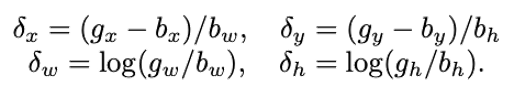


You can test out that things work appropriately on a few examples below

<img src="https://docs.google.com/uc?export=download&id=1kCYtYLqADe3uiKYQsGwbGAgN-JwutzGv" style="width:500px;height:250px;">
<caption><center> <b>Transforming the bounding boxes to deltas and vice versa</b><br> </center></caption>

In [ ]:
def bbox2delta(proposals, gt, means=[0, 0, 0, 0], stds=[1, 1, 1, 1]):
    assert proposals.size() == gt.size()

    proposals = proposals.float()

    gt = gt.float()
    # Defining the centre of the proposed boxes
    px = (proposals[..., 0] + proposals[..., 2]) * 0.5
    py = (proposals[..., 1] + proposals[..., 3]) * 0.5
    # Defining height and width of the proposed boxes
    pw = proposals[..., 2] - proposals[..., 0] + 1.0
    ph = proposals[..., 3] - proposals[..., 1] + 1.0

    # Defining the centre of the ground_truth boxes
    gx = (gt[..., 0] + gt[..., 2]) * 0.5
    gy = (gt[..., 1] + gt[..., 3]) * 0.5
    # Defining height and width of the ground truth boxes
    gw = gt[..., 2] - gt[..., 0] + 1.0
    gh = gt[..., 3] - gt[..., 1] + 1.0

    # Defining delta 
    dx = (gx - px) / pw
    dy = (gy - py) / ph
    dw = torch.log(gw / pw)
    dh = torch.log(gh / ph)
    deltas = torch.stack([dx, dy, dw, dh], dim=-1)

    
    means = deltas.new_tensor(means).unsqueeze(0)
    stds = deltas.new_tensor(stds).unsqueeze(0)
    deltas = deltas.sub_(means).div_(stds)

    return deltas


def delta2bbox(rois,
               deltas,
               means=[0, 0, 0, 0],
               stds=[1, 1, 1, 1],
               max_shape=None,
               wh_ratio_clip=1 / 1000):
    """
    Apply deltas to shift/scale base boxes.

    Typically the rois are anchor or proposed bounding boxes and the deltas are
    network outputs used to shift/scale those boxes.

    Args:
        rois (Tensor): boxes to be transformed. Has shape (N, 4)
        deltas (Tensor): encoded offsets with respect to each roi.
            Has shape (N, 4). Note N = num_anchors * W * H when rois is a grid
            of anchors. Offset encoding follows [1]_.
        means (list): denormalizing means for delta coordinates
        stds (list): denormalizing standard deviation for delta coordinates
        max_shape (tuple[int, int]): maximum bounds for boxes. specifies (H, W)
        wh_ratio_clip (float): maximum aspect ratio for boxes.

    Returns:
        Tensor: boxes with shape (N, 4), where columns represent
            tl_x, tl_y, br_x, br_y.


    """
    means = deltas.new_tensor(means).repeat(1, deltas.size(1) // 4)
    stds = deltas.new_tensor(stds).repeat(1, deltas.size(1) // 4)
    denorm_deltas = deltas * stds + means
    dx = denorm_deltas[:, 0::4] #
    dy = denorm_deltas[:, 1::4]
    dw = denorm_deltas[:, 2::4]
    dh = denorm_deltas[:, 3::4]
    max_ratio = np.abs(np.log(wh_ratio_clip)) # We set a maximum expansion ratio for the deltas. 
    dw = dw.clamp(min=-max_ratio, max=max_ratio)
    dh = dh.clamp(min=-max_ratio, max=max_ratio)
    # Compute center of each roi
    px = ((rois[:, 0] + rois[:, 2]) * 0.5).unsqueeze(1).expand_as(dx)
    py = ((rois[:, 1] + rois[:, 3]) * 0.5).unsqueeze(1).expand_as(dy)
    # Compute width/height of each roi
    pw = (rois[:, 2] - rois[:, 0] + 1.0).unsqueeze(1).expand_as(dw)
    ph = (rois[:, 3] - rois[:, 1] + 1.0).unsqueeze(1).expand_as(dh)
    # Use exp(network energy) to enlarge/shrink each roi
    gw = pw * dw.exp()
    gh = ph * dh.exp()
   
    # Use network energy to shift the center of each roi
    gx = torch.addcmul(px, 1, pw, dx)  # gx = px + pw * dx
    gy = torch.addcmul(py, 1, ph, dy)  # gy = py + ph * dy
    # Convert center-xy/width/height to top-left, bottom-right
    x1 = gx - gw * 0.5 + 0.5
    y1 = gy - gh * 0.5 + 0.5
    x2 = gx + gw * 0.5 - 0.5
    y2 = gy + gh * 0.5 - 0.5

    # making sure that the indices are well ordered
    x1_fin = torch.min(x1,x2)
    x2_fin = torch.max(x1,x2)
    y1_fin = torch.min(y1,y2)
    y2_fin = torch.max(y1,y2)
    if max_shape is not None:  # Just in case we want to limit the shape. 
        x1_fin = x1_fin.clamp(min=0, max=max_shape[1] - 1)
        y1_fin = y1_fin.clamp(min=0, max=max_shape[0] - 1)
        x2_fin = x2_fin.clamp(min=0, max=max_shape[1] - 1)
        y2_fin = y2_fin.clamp(min=0, max=max_shape[0] - 1)
    bboxes = torch.stack([x1_fin, y1_fin, x2_fin, y2_fin], dim=-1).view_as(deltas)
    return bboxes



# **Part 4 - Implementing our networks**



<img src="https://docs.google.com/uc?export=download&id=1KaSU2OUsCMKjk8fYd49_R35ouomPmhCo" style="width:500px;height:250px;">
<caption><center> <b>Implementing Networks and Loss functions</b><br> </center></caption>

<img src="https://docs.google.com/uc?export=download&id=1027vJCH49nMyB_hyigUIUvXqWZgE0g3-" style="width:500px;height:250px;">
<caption><center> <b>Schematic of a general Faster RCNN architecture.</b> Source: https://towardsdatascience.com/faster-rcnn-object-detection-f865e5ed7fc4<br> </center></caption>

## **Backbone**
A UNet backbone network similar to the one used for lecture 5 is used for our purpose.

In [ ]:
class _EncoderBN(nn.Module):
    def __init__(self, in_channels, out_channels, k, padd, dropout=False):
        super(_EncoderBN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=k,
                               padding=padd)
        self.BN1a = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=k,
                               padding=padd)
        self.BN2a = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = x.type(torch.float32)
        x = F.leaky_relu(self.BN1a(self.conv1(x)), inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)), inplace=True)
        return x


class _DecoderBN(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size=3,
                               padding=1)
        self.BN1a = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, middle_channels, kernel_size=3,
                               padding=1)
        self.BN2a = nn.BatchNorm2d(middle_channels)
        self.convT = nn.ConvTranspose2d(middle_channels, out_channels,
                                        kernel_size=2, stride=2)

    def forward(self, x):
        x = F.leaky_relu(self.BN1a(self.conv1(x)), inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)), inplace=True)
        return self.convT(x)


class prefinalBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(prefinalBN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               padding=1)
        self.BN1a = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1)
        self.BN2a = nn.BatchNorm2d(out_channels)
        nn.InstanceNorm1d

    def forward(self, x):
        x = F.leaky_relu(self.BN1a(self.conv1(x)), inplace=True)
        x = F.leaky_relu(self.BN2a(self.conv2(x)), inplace=True)
        return x


class ADABN(nn.Module):
    def __init__(self, num_classes, num_channels):
        super(ADABN, self).__init__()

        self.enc1 = _EncoderBN(num_channels, 64, 5, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = _EncoderBN(64, 96, 3, 1)
        self.enc3 = _EncoderBN(96, 128, 3, 1)
        self.enc4 = _EncoderBN(128, 256, 3, 1)
        self.center = _DecoderBN(256, 512, 256)
        self.dec4 = _DecoderBN(512, 256, 128)
        self.dec3 = _DecoderBN(256, 128, 96)
        self.dec2 = _DecoderBN(96 * 2, 96, 64)
        self.dec1 = prefinalBN(128, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        initialize_weights(self)

    def forward(self, x):
        print("What gets in backbone")
        print(x.shape)
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = F.dropout(self.enc4(self.pool(enc3)))

        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([center, enc4], 1))
        dec3 = self.dec3(torch.cat([dec4, enc3], 1))
        dec2 = self.dec2(torch.cat([dec3, enc2], 1))
        dec1 = self.dec1(torch.cat([dec2, enc1], 1))

        final = self.final(dec1)

        print("What gets out")
        print(final.shape)
        return (final, enc1, enc2, enc3, enc4, center, dec4, dec3, dec2, dec1)

## **RPN Head**
The RPN Head is defined as convolutional layer whose output going through a ReLU activation function is shared by a regression branch and a classification branch each of which is expressed as a convolutional layer of kernel 1 with respectively 4 * num_anchors and 2 * num_anchors channels as output. Following these guidelines, complete the network below.

Why 2xnum_anchors for the classification? The RPN is only there to suggest **positive** boxes. Thus, you only one the classes to be 0 and 1 for this task, independently of how many classes you've got on the RCNN side.


In [ ]:
class RPNHead(nn.Module):
    def __init__(self, num_classes, num_channels, num_feat, num_anchors):
        super(RPNHead, self).__init__()
        self.num_anchors = num_anchors 
        self.in_channels = num_channels
        self.feat_channels = num_feat # The feature map from where we infer the classification and the regions have self.feat_channels (Dim: W_X x W_Y x C)
        self.cls_out_channels = num_classes

        self.rpn_conv = nn.Conv2d(
            self.in_channels, self.feat_channels, 3, padding=1) # Last branch before branching classificatio + regression
        self.rpn_cls = nn.Conv2d(self.feat_channels,
                                 self.num_anchors * self.cls_out_channels, 1)

        self.rpn_reg = nn.Conv2d(self.feat_channels, self.num_anchors * 4, 1) 
        initialize_weights(self)

    def forward(self, x):
        first_conv = F.relu(self.rpn_conv(x))
        cls_pred = self.rpn_cls(first_conv)
        bbox_pred = self.rpn_reg(first_conv)
        return cls_pred, bbox_pred, first_conv

## **RCNN Head**
Classically, the RCNN Head is defined as 2 fully connected layers interleaved with ReLU whose output is shared by a regression branch and a classification branch each of which is expressed as a fully connected layer with respectively 4 and #number of classes channels as output. Following these guidelines, complete the network below. As the input of the RCNN Head is a 7x7 x number of feature maps, it needs to be flattened (or the input needs to be averaged) before being fed to the network. In our case we decided to use the flattened version of the input.

In [ ]:
class BBoxHead(nn.Module):
    def __init__(self, num_classes, num_channels, num_feat=88):
        super(BBoxHead, self).__init__()
        self.num_classes = num_classes
        self.num_channels = num_channels
        self.num_feat = num_feat
        self.fully_conn_1 = nn.Linear(num_channels, num_feat)
        self.fully_conn_2 = nn.Linear(num_feat, num_feat)
        self.fc_reg = nn.Linear(num_feat, 4)
        self.fc_cls = nn.Linear(num_feat, num_classes)
        initialize_weights(self)

    def forward(self, x):
        x = x.flatten(1)
        print(x.shape)
        fc1 = F.relu(self.fully_conn_1(x))
        fc2 = F.relu(self.fully_conn_2(fc1))
        cls_pred = self.fc_cls(fc2)
        bbox_pred = self.fc_reg(fc2)
        return cls_pred, bbox_pred

## **Definition of loss functions**
We have seen multiple loss functions in the lecture. In addition to the weighted soft dice, complete the implementation of the smooth l1 loss and of the focal loss.
As a reminder:

Smooth L1 (&beta;=1):

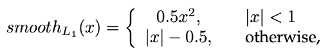


Focal Loss (often reweighted by a factor `\alpha`

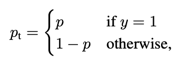

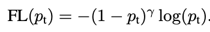

In [ ]:
def weighted_soft_dice_loss(output, target, weights):
    s = (10e-20)
    output = output.type(torch.FloatTensor)
    target = target.type(torch.FloatTensor)

    intersect = torch.sum(output * target * weights)
    dice = 2 * intersect / (torch.sum(output*weights) + torch.sum(
        target*weights)+s)
    return 1 - dice

def cross_entropy(pred, label, weight=None, reduction='mean',
                  avg_factor=None):
    # element-wise losses
    # print((pred[:,:]*weight).sum(), label.sum(), pred.shape)
    loss = F.cross_entropy(pred, label.type(torch.LongTensor), reduction='none')

    # apply weights and do the reduction
    if weight is not None:
        weight = weight.float()
    loss = (loss * weight).sum()/weight.sum()

    return loss


def focal_loss(inputs, targets, alpha=1, gamma=2, weights=None):

      # Hint: Look at the Retina Net implementation in the slides!
        
        BCE_loss = F.cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = -1 * alpha * (1-pt)**gamma * BCE_loss
        # test = torch.nn.functional.softmax(inputs,1)[:,1,:] > 0.5
        # print((targets*weights).sum(),weights.sum(),
        #       (test*targets*weights).sum(),
        #       (test*weights).sum())

        if weights is not None:
            if weights.sum() == 0:
                return 0
            return torch.sum(F_loss*weights)/weights.sum()
        else:
            return F_loss.mean()


def smooth_l1_loss(pred, target, weights=None, beta=1.0):
    assert beta > 0
    assert pred.size() == target.size() and target.numel() > 0
    diff = torch.abs(pred - target)
    print(target.shape, pred.shape)
    loss = torch.where(diff < beta, 0.5 * diff * diff / beta,
                       diff - 0.5 * beta)
    if weights is None:
        return loss.mean()
    else:
        return (loss * weights).sum() / weights.sum()


# **Part 5 - Putting things together**



<img src="https://docs.google.com/uc?export=download&id=1tRUG6s7-0oMbqPRQdvghuw1SsPmE1E2G" style="width:500px;height:250px;">
<caption><center> <b>Targets for RPN, Non-max suppression and two-stage model creation</b><br> </center></caption>

## **Creating targets for RPN**

We have all what we need to appropriately train the RPN. We need however to find what are the targets and make sure that the imbalance between negative and positive samples is taken care of.

Complete the following `target_anchors_single` function that takes as argument the list of anchors, the boxes and associated labels, a possible mask of where to accept anchors from (in our case, we want to stay in the brain)

In [ ]:
def target_anchors_single(flat_anchors, gt_bboxes, gt_labels,
                          img_shape, mask=None,sampling=True):
    """
    Among the choice of anchors across the feature map, decides of the assignment to ground truth boxes 
    in order to create the necessary tensors for evaluation of the RPN head
    Take as arguments:
    flat_anchors : the list of anchors across the whole feature map
    gt_bboxes : the ground truth boxes
    gt_labels: the associated labels
    img_shape: the spatial shape of the image
    mask: mask over which anchors are allowed
    sampling: whether a random sampling scheme is performed
    """
    
    # Define which anchors are appropriate to use. 
    inside_flags = anchor_inside_flags(flat_anchors, torch.from_numpy(
        np.asarray((1,) * len(flat_anchors))), img_shape, mask=mask)
    if not inside_flags.any():
        return (None,) * 6
    # assign gt and sample anchors
    # assign gt and sample anchors with a minimum iou for assignment of 0.3 and a positive assignment for boxes with IoU above 0.7 

    anchors = flat_anchors[inside_flags, :]
    assign_anchors = MaxIoUAssigner(0.7, 0.3)
    assign_results = assign_anchors.assign(anchors, gt_bboxes,
                                           gt_labels=gt_labels)
    
    # Randomly sample to get 256 boxes with a 50/50 ratio of positive vs negative boxes
    # Hint: remember the auxiliary sampling functions we defined!
    # We use for that the class RandomSampler that has been defined before.
    sample_anchors = RandomSampler(256, 0.5, )
    sampled_boxes = sample_anchors.sample(assign_results, anchors,
                                          gt_bboxes, gt_labels)

    # Initialise the target for bounding boxes, the labels and associated weights
    num_valid_anchors = anchors.shape[0]
    bbox_targets = torch.zeros_like(anchors)
    bbox_weights = torch.zeros_like(anchors)
    labels = anchors.new_zeros(num_valid_anchors, dtype=torch.long)
    label_weights = anchors.new_zeros(num_valid_anchors, dtype=torch.float)

    # Identify positive and negative indices from the sampled_boxes
    pos_inds = sampled_boxes.pos_inds
    neg_inds = sampled_boxes.neg_inds
    # We need only to learn boxes targets from positive samples. In this case, the weights should be 1
    if len(pos_inds) > 0:
        pos_bbox_targets = bbox2delta(sampled_boxes.pos_bboxes,
                                      sampled_boxes.pos_gt_bboxes)
        bbox_targets[pos_inds, :] = pos_bbox_targets
        bbox_weights[pos_inds, :] = 1.0
        label_weights[pos_inds] = 1
        if gt_labels is None:
            # If there are no labels you put 1 only. 
            labels[pos_inds] = 1
        else:
            labels[pos_inds] = gt_labels[sampled_boxes.pos_assigned_gt_inds]
            
    # For negative samples, we need to learn from these examples so we need to set the weight of the labelling to 1
    if len(neg_inds) > 0:
        label_weights[neg_inds] = 1.0

    # map up to original set of anchors
    num_total_anchors = flat_anchors.size(0)
    labels = unmap(labels, num_total_anchors, inside_flags)
    label_weights = unmap(label_weights, num_total_anchors, inside_flags)
    bbox_targets = unmap(bbox_targets, num_total_anchors, inside_flags)
    bbox_weights = unmap(bbox_weights, num_total_anchors, inside_flags)

    return (labels, label_weights, bbox_targets, bbox_weights, pos_inds,
            neg_inds)

## **Creating proposals from output of RPN to input of RCNN**

Complete the `create_proposals` function that takes in the scores of the rpn that have already been reshaped to be of size (2, total_num_anchors), the associated targets delta, the anchors, GT boxes and labels as input.
Optionally we can a padding around the defined boxes prior to application of ROI align in order to have a bit more context.

The aim of this function is to perform the **non-maximum suppression** on the anchors selected by the RPN. Applying the delta over the RPN is optional as indicated by the apply_rpn flag.

*Non-Maximum Suppression (NMS) is used in order to overcome the low precision of the proposals done by the RPN network. The RPN is in charge of providing proposals to the RCNN, and thus high recall is prioritized, sometimes in expense of loose constraints that create a lot of false positive samples. Because allowing for many proposals into the RCNN network increases the computational cost, NMS is previously applied to filter the proposals according to their scores.*


<img src="https://docs.google.com/uc?export=download&id=17xXgo1fCyfPnn0VRLhPu-T90fDF3QTlV" style="width:500px;height:250px;">
<caption><center> <b>Non-Max suppression example</b> Source: https://www.kdnuggets.com/2018/09/object-detection-image-classification-yolo.html <br> </center></caption>

In [ ]:

def create_proposals(rpn_cls, rpn_bbox, anchors, gt_bboxes, gt_labels,
                     apply_rpn=False, add_pad=5, shape=[128,128],
                     num_nms_post=1000, num_nms_pre=2000):
    """
    From the output of the RPN, this function allows to sample the appropriate number of proposals 
    to go to the RCNN stage
    Take as input rpn_cls, rpn_bbox output of the RPNHead, the anchors, ground_truth boxes and associated labels. 
    The correction is applied to the boxes if apply_rpn is set to True otherwise original anchors found positive are directly used
    num_nms_pre is the number of proposals prior to NMS correction
    num_nms_post is the maximum number of proposals after NMS correction
    """
    # Identify the top num_nms_pre boxes according to RPNHead 
    # Hint: once you softmax the outputs, to select the best boxes, you can use topk
    # Ref: https://pytorch.org/docs/stable/generated/torch.topk.html
    
    softmax_cls = rpn_cls.permute(1, 0).softmax(dim=1)[:, 1] # The "scores" given by the RPN are ran through a softmax. 
    softmax_top, topk_inds = softmax_cls.topk(num_nms_pre)
    rpn_box_top = rpn_bbox[topk_inds, :]
    anchors_top = anchors[topk_inds, :]
    if apply_rpn:
        applied_box = delta2bbox(rpn_box_top, anchors_top)
    else:
        applied_box = anchors_top
    
    # Perform NMS correction with IoU 0.7 - cf torchvision.ops.nms function
    nms_idx = torchvision.ops.nms(applied_box, softmax_top, 0.7) # - redundancy

    nms_boxes = applied_box[list(nms_idx.numpy())[0:num_nms_post], :]
    # Remove proposals to close to the edge
    # Multiply booleans
    valid_nms = (nms_boxes[:,0] > add_pad ) * \
                (nms_boxes[:, 1] > add_pad) * \
                (nms_boxes[:,2] < shape[0]-add_pad) * \
                (nms_boxes[:, 3] < shape[1]-add_pad)
    nms_boxes = nms_boxes[valid_nms,:]
    num_nms_post = np.minimum(num_nms_post, nms_boxes.shape)[0]
    # print(num_nms_post, " is new num_nms_post")
    bbox_targets = torch.zeros(num_nms_post, 4)
    bbox_weights = torch.zeros(num_nms_post, 4)
    labels = torch.zeros(num_nms_post).type(torch.LongTensor)
    label_weights = torch.zeros(num_nms_post)
    assign_newboxes = MaxIoUAssigner(0.7, 0.3)
    assign_result = assign_newboxes.assign(nms_boxes, gt_bboxes, gt_labels)
    length_pos = (assign_result.gt_inds > 0).sum()
    
    # Define the anchors randomly chosen for next stage 
    # Similarly to what was done for the RPN, sample appropriately the proposals so as to keep with the ratio 1:2. 
    # Indicate the maximum length of samples according to length_pos
    sample_anchors = RandomSampler(np.minimum(1000,
                                              3*length_pos+1), 0.3)
    sampled_boxes = sample_anchors.sample(assign_result, nms_boxes,
                                          gt_bboxes, gt_labels)


    pos_inds = sampled_boxes.pos_inds
    neg_inds = sampled_boxes.neg_inds

    pos_inds = list(pos_inds.numpy())
    neg_inds = list(neg_inds.numpy())

    if len(pos_inds) > 0:
        pos_bbox_targets = bbox2delta(sampled_boxes.pos_bboxes,
                                      sampled_boxes.pos_gt_bboxes)
        bbox_targets[pos_inds, :] = pos_bbox_targets
        bbox_weights[pos_inds, :] = 1.0
        if gt_labels is None:
            labels[pos_inds] = 1
        else:

            labels[pos_inds] = gt_labels[sampled_boxes.pos_assigned_gt_inds]
    labels[neg_inds] = 0
    label_weights[neg_inds] = 1
    label_weights[pos_inds] = 1
    
    # Add a padding around the boxes using add_pad argument
    nms_boxes = nms_boxes + torch.Tensor([[-add_pad],[-add_pad],[add_pad],[add_pad]]).repeat_interleave(nms_boxes.shape[0],1).transpose(1,0)

    return labels, label_weights, bbox_targets, bbox_weights, nms_boxes, \
           pos_inds, neg_inds



## **Definition of the training process**
The following class defines the two stage detector

In the first instance, from the definition of the backbone network, complete the extract_feat function so that it returns the layer before the final output as well as the final class

Then complete the `forward_train` for the different missing pieces. Don't forget to use the `multi_apply` function each time you have to deal with the fact that you don't have the same boxes defined for each of the images in your batch.

In [ ]:
class TwoStageDetector(nn.Module):
    """Base class for two-stage detectors.

    Two-stage detectors typically consisting of a region proposal network and a
    task-specific regression head.
    """

    def __init__(self,
                 backbone,
                 rpn_head=None,
                 bbox_roi_extractor=None,
                 rcnn_head=None,
                #  pretrained='/Users/csudre/Documents/Teaching/AML/AML_lecture_5/Backbone_OD.pt'
                pretrained = None):
        super(TwoStageDetector, self).__init__()
        self.backbone = backbone

        if rpn_head is not None:
            self.rpn_head = rpn_head

        if rcnn_head is not None:
            self.bbox_roi_extractor = bbox_roi_extractor
            self.rcnn_head = rcnn_head

        self.init_weights(pretrained=pretrained)

    @property
    def with_rpn(self):
        return hasattr(self, 'rpn_head') and self.rpn_head is not None

    @property
    def with_bbox(self):
        return hasattr(self, 'rcnn_head') and self.rcnn_head is not None

    def init_weights(self, pretrained=None):
        if pretrained is not None:
            if 'backbone' in pretrained.keys():
                self.backbone.load_state_dict(torch.load(pretrained['backbone'], map_location=torch.device(device)))
            if 'rpn_head' in pretrained.keys():
                self.rpn_head.load_state_dict(torch.load(pretrained['rpn_head'], map_location=torch.device(device)))
            if 'rcnn_head' in pretrained.keys():
                self.rcnn_head.load_state_dict(torch.load(pretrained['rcnn_head'], map_location=torch.device(device)))
            if 'full' in pretrained.keys():
                self.load_state_dict(
                torch.load(pretrained, map_location=torch.device(device)))

    def extract_feat(self, img):
        """Directly extract features from the backbone+neck
        """
        list_feat = self.backbone(img)
        return list_feat[-1], list_feat[0]

    def forward_train(self,
                      img,
                      gt_bboxes,
                      img_meta=None,
                      gt_labels=None,
                      gt_bboxes_ignore=None,
                      label_seg=None,
                      training_stage=['rpn_head']
                      ):
        """
        Args:
            img (Tensor): of shape (N, C, H, W) encoding input images.
                Typically these should be mean centered and std scaled.

            img_meta (list[dict]): list of image info dict where each dict has:
                'img_shape', 'scale_factor', 'flip', and may also contain
                'filename', 'ori_shape', 'pad_shape', and 'img_norm_cfg'.
                For details on the values of these keys see
                `mmdet/datasets/pipelines/formatting.py:Collect`.

            gt_bboxes (list[Tensor]): each item are the truth boxes for each
                image in [tl_x, tl_y, br_x, br_y] format.

            gt_labels (list[Tensor]): class indices corresponding to each box

            gt_bboxes_ignore (None | list[Tensor]): specify which bounding
                boxes can be ignored when computing the loss.

            gt_masks (None | Tensor) : true segmentation masks for each box
                used if the architecture supports a segmentation task.

            proposals : override rpn proposals with custom proposals. Use when
                `with_rpn` is False.

        Returns:
            dict[str, Tensor]: a dictionary of loss components
        """
        losses = dict()
        x, full = self.extract_feat(img)
        print("Features extracted")
        if 'backbone' in training_stage and label_seg is not None:
            print("Training backbone")

            # soft_dice_loss ? 
            losses['backbone'] = weighted_soft_dice_loss(torch.sigmoid(full),
                                                Variable(label_seg, requires_grad=True))
            
            test_out = torch.sigmoid(full) > 0.5
            print(test_out.sum())
            losses['rpn_cls'] = 0
            losses['rpn_bbox'] = 0
            losses['rcnn_cls'] = 0
            losses['rcnn_bbox'] = 0

        if 'rpn_head' in training_stage or 'rcnn_head' in training_stage:
            print(training_stage)
            print("running RPN")
            anchors_gen = AnchorGenerator((2, 2), (0.5, 1, 2), (0.5, 1, 2))
            anchors = anchors_gen.grid_anchors(img.shape[-2:], stride=1)
            print("anchors generated")
            anchors_full = [anchors for i in range(0, len(gt_bboxes))]
            img_shape_full = [img[i].shape[-2:] for i in
                              range(0, len(gt_bboxes))]
            valid_flags_full = [(1,) * len(anchors) for i in
                                range(0, len(gt_bboxes))]
            if gt_labels is None:
                gt_labels = [
                    torch.from_numpy(np.asarray((1,) * len(gt_bboxes[i])))
                    for i in range(0, len(gt_bboxes))]

            # RPN forward and loss
            mask_full = img>-2
            rpn_cls, rpn_bbox, _ = self.rpn_head(x)
            print("RPN performed")
            (labels, label_weights, bbox_targets, bbox_weights, pos_inds_list,
             neg_inds_list) = multi_apply(target_anchors_single, 
                                          anchors_full,
                                          gt_bboxes,
                                          gt_labels,
                                          img_shape_full,
                                          mask_full)
            print("Assignment RPN done")

            rpn_cls_perm = rpn_cls.permute(0, 2, 3, 1)
            print(rpn_cls.shape)
            # len(gt_bboxes) batch size bcse it's a list of lists (nested lists)
            # -1: 128*128*9
            #2 : "class" (pos/-)
            # DIMENSIONS???????
            rpn_cls_res = rpn_cls_perm.reshape([len(gt_bboxes), -1, 2])
            rpn_prob = torch.nn.functional.softmax(rpn_cls_res, dim=-1)[:,:,1]

            rpn_cls_fin = rpn_cls_res.permute(0, 2, 1)
            rpn_bbox_perm = rpn_bbox.permute(0, 2, 3, 1)
            rpn_bbox_res = rpn_bbox_perm.reshape([len(gt_bboxes), -1, 4])

            print("Reshaping done")
            for i in range(len(gt_bboxes)):
                if labels[i] is None:
                    # labels[i] = torch.zeros_like(anchors[:,0])
                    labels[i] = torch.zeros_like(anchors[:, 0]).type(torch.LongTensor)
                    label_weights[i] = torch.zeros_like(anchors[:,0])
                    bbox_targets[i] = torch.zeros_like(anchors)
                    bbox_weights[i] = torch.zeros_like(anchors)

            # labels_fin = torch.stack(labels).type(torch.FloatTensor)
            labels_fin = torch.stack(labels)
            label_weights_fin = torch.stack(label_weights).type(
                torch.FloatTensor)
            loss_cls = cross_entropy(rpn_cls_fin, torch.stack(labels),
                                     torch.stack(label_weights))
            loss_cls_focal = focal_loss(rpn_cls_fin,
                                        targets=labels_fin.type(torch.LongTensor),
                                        weights=Variable(label_weights_fin, requires_grad=True))

            loss_cls_dice = weighted_soft_dice_loss(rpn_prob,
                                                    Variable(labels_fin.type(torch.FloatTensor), requires_grad=True),
                                                    Variable(label_weights_fin, requires_grad=True))
            
            loss_cls = loss_cls_dice + loss_cls_focal
            print(loss_cls_dice, loss_cls_focal)
            loss_rpnbb = smooth_l1_loss(rpn_bbox_res, torch.stack(bbox_targets),
                                        torch.stack(label_weights).repeat(1, 4).reshape([len(gt_bboxes), -1, 4]))            
            losses['rpn_cls'] = loss_cls
            losses['rpn_bbox'] = loss_rpnbb
            losses['rcnn_cls'] = 0
            losses['rcnn_bbox'] = 0
            print("Loss RPN calculated \n")
        if 'rcnn_head' in training_stage:
            # Create proposals by applying bbox pred
            rcnn_lab, rcnn_lab_weights, rcnn_targets, rcnn_weights_bbox, \
            nms_boxes, rcnn_pos_inds, rcnn_neg_inds = multi_apply(create_proposals,
                                                                  rpn_cls_fin,
                                                                  rpn_bbox_res, 
                                                                  anchors_full,
                                                                  gt_bboxes,
                                                                  gt_labels,
                                                                  (False,)*len(gt_bboxes))
            print("NMS performed for proposal \n")
            # Number of proposals is a batch
            rcnn_lab = torch.cat(rcnn_lab)
            rcnn_lab_weights = torch.cat(rcnn_lab_weights)
            rcnn_weights_box = torch.cat(rcnn_weights_bbox)
            rcnn_targets = torch.cat(rcnn_targets)

            # Transformation to get all corresponding aligned ROI (bbox extraction) using roi align with output size 7x7

            aligned_feat = torchvision.ops.roi_align(x, nms_boxes, 7)
            print("Alignment performed \n", aligned_feat.shape)

            # Apply RCNN head to ROIs
            
            rcnn_cls, rcnn_bbox = self.rcnn_head(aligned_feat)
            print(rcnn_cls.shape, rcnn_bbox.shape, rcnn_lab.shape,
                  rcnn_targets.shape)
            loss_rcnn_cls = cross_entropy(rcnn_cls, rcnn_lab, rcnn_lab_weights)
            loss_rcnn_bbox = smooth_l1_loss(rcnn_bbox, rcnn_targets)
            losses['loss_rcnn_cls'] = loss_rcnn_cls
            losses['losses_rcnn_bbox'] = loss_rcnn_bbox
        return losses


# Part 6 Inference

<b> Inference: The process of using the trained model to make a prediction </b>

Complete the following function `inference_rpn` to get first the appropriate proposals function - Don't forget the same padding as you had for the training -

Complete the function `inference_rcnn` that calls on to `inference_rpn` and provide the final output.

<img src="https://docs.google.com/uc?export=download&id=1qosFHp3SfILtyix7H7MQbuB9QNyvMtAg" style="width:500px;height:250px;">
<caption><center> <b>Final steps: Inference and model improvement</b><br> </center></caption>

In [ ]:
def inference_rpn(model, img, num_box=200, padding=5,size=(5, 5), scales=(0.5, 1, 2), ratios=(0.5, 1, 2)):
        x, final = model.extract_feat(img)
        # We create a mask so as to get rid of all the non-brain proposals. We will then discard all the boxes out of 
        # mask
        mask = img>-2
        rpn_cls, rpn_bbox,_ = model.rpn_head(x)
        anchors_gen = AnchorGenerator(size,scales,ratios)
        anchors = anchors_gen.grid_anchors(img.shape[-2:], stride=1)
        anchors_full = [anchors for i in range(img.shape[0])] 
        
        # Select the best proposals given the scores from the rpn and the predicted delta. num_box indicates half
        # the number of boxes that should be selected from the RPN stage
        def select_best_prop(rpn_cls, anchors, rpn_bbox, num_box, img):
            #print("rpn_cls", rpn_cls.shape, "anchors_shape", anchors.shape, "rpn bbox shape", rpn_bbox.shape,  "shape of the image", img.shape)
            valid = (img > -2).view(-1).repeat_interleave(9)
            #print(valid.shape)
            rpn_cls = rpn_cls.reshape([18,-1])
            rpn_cls = rpn_cls.permute(1,0)
            rpn_cls = rpn_cls.reshape([-1, 9, 2])
            rpn_cls = rpn_cls.reshape([-1, 2])
            scores = rpn_cls.softmax(dim=1)[:,1]
            scores = torch.where(valid, scores,torch.ones_like(scores)*-1.0)
            _, best_anchors = scores.topk(num_box*2, dim=0)
            anchors_selected = anchors[best_anchors, :]
            rpn_bbox = rpn_bbox.reshape([36, -1])
            rpn_bbox = rpn_bbox.permute(1,0)
            rpn_bbox = rpn_bbox.reshape([-1, 9, 4])
            rpn_bbox = rpn_bbox.reshape([-1, 4])
            rpn_selected = rpn_bbox[best_anchors, :]
            anchors_modified = delta2bbox( anchors_selected, rpn_selected)
            scores_best = scores[best_anchors]
            scores_mod = scores_best
            scores_nomod = scores_best
            
            # Select only anchors valid according to padding possibilities
            if padding > 0:
                indices_valid_mod = (anchors_modified[:,0]>padding) * (anchors_modified[:,1] > padding) * (anchors_modified[:,2] < img.shape[1] - padding) * (anchors_modified[:,3]<img.shape[2]-padding)  
                indices_valid_nomod = (anchors_selected[:,0]>padding) * (anchors_selected[:,1] > padding) * (anchors_selected[:,2] < img.shape[1] - padding) * (anchors_selected[:,3]<img.shape[2]-padding)
                anchors_modified = anchors_modified[indices_valid_mod, :]
                anchors_selected = anchors_selected[indices_valid_nomod, :]
                scores_mod = scores_best[indices_valid_mod]
                scores_nomod = scores_best[indices_valid_nomod]
                
            # Perform NMS with IoU of 0.5
            final_idx = torchvision.ops.nms(anchors_modified, scores_mod, 0.5)
            final_idx_nomod = torchvision.ops.nms(anchors_selected, scores_nomod, 0.5)
            len_final = np.minimum(num_box, final_idx.shape[0])
            #print("Final number of boxes: ", len_final)
            final_anchors = anchors_modified[final_idx[:len_final],:]
            final_anchors_nomod = anchors_selected[final_idx_nomod[:np.minimum(num_box,final_idx_nomod.shape[0])],:]
            scores_final = scores_mod[:len_final]
            scores_final_nomod = scores_nomod[:np.minimum(num_box,final_idx_nomod.shape[0])]
            
            # Apply padding to be able to perform ROI align afterwards
            final_anchors  = final_anchors + torch.Tensor([[-padding],[-padding],[padding],[padding]]).repeat_interleave(final_anchors.shape[0],1).transpose(1,0)
            final_anchors_nomod = final_anchors_nomod + torch.Tensor([[-padding],[-padding],[padding],[padding]]).repeat_interleave(final_anchors_nomod.shape[0],1).transpose(1,0)
            return final_anchors, scores_final,final_anchors_nomod,scores_final_nomod
        # print(rpn_cls.shape, len(anchors_full), rpn_bbox.shape)
        (nms_proposals, scores_final, final_nomod, scores_final_nomod) = multi_apply(select_best_prop,
                                                                                     rpn_cls, 
                                                                                     anchors_full, 
                                                                                     rpn_bbox, 
                                                                                     (num_box,)*len(anchors_full),img)
        # print(len(nms_proposals), "is length of nms proposals")

        return x, nms_proposals, torch.sigmoid(final), rpn_cls, final_nomod, scores_final, scores_final_nomod


In [ ]:
def inference_rcnn(model, img, thresh=0.4, padding=5):
        features, proposals, backbone_out, scores_anchors, selected_anchors, scores_final, scores_final_nomod  = inference_rpn(model, img, 500)

        averaged_features = torchvision.ops.roi_align(features, 
                                                      selected_anchors,
                                                      output_size=7)
        print("What goes in the RCNN has shape... ", averaged_features.shape)
        rcnn_cls, rcnn_bbox = model.rcnn_head(averaged_features)
        
        print("And the output is... ", rcnn_cls.shape, rcnn_bbox.shape) #no batch 
        list_cls = []
        list_box = []
        num_start = 0
        
        if padding > 0:
            proposals_new = []
            anchors_new = []
            for (p,s) in zip(proposals, selected_anchors):
                p_n = p -  torch.Tensor([[-padding],[-padding],[padding],[padding]]).repeat_interleave(p.shape[0],1).transpose(1,0)
                s_n = s -  torch.Tensor([[-padding],[-padding],[padding],[padding]]).repeat_interleave(s.shape[0],1).transpose(1,0)
                proposals_new.append(p_n)
                anchors_new.append(s_n)
            proposals = proposals_new
            selected_anchors = anchors_new

        for i in range(features.shape[0]):
            num_proposals = selected_anchors[i].shape[0] # use order to map them back to the images 
            num_end = num_start + num_proposals
            list_cls.append(rcnn_cls[num_start:num_end,:])
            list_box.append(rcnn_bbox[num_start:num_end,:])
            num_start = num_end
           
        def select_final(proposal, rcnn_cls, rcnn_bbox, thresh=0.2, padding=5):
            rcnn_cls_soft = torch.softmax(rcnn_cls,1)[:,1]
            
            # We select indices for which probability is above our threshold
            indices_choice = (rcnn_cls_soft>thresh).view(-1).squeeze().type(torch.BoolTensor)
            temp_proposals = proposal[indices_choice,:]
            temp_delta = rcnn_bbox[indices_choice,:]
            temp_cls = rcnn_cls[indices_choice,:]
            temp_bboxes = delta2bbox(temp_proposals, temp_delta)
            width = temp_bboxes[:,2]-temp_bboxes[:,0]+1
            height = temp_bboxes[:,3] - temp_bboxes[:,1]+1
            
            # We remove too big boxes
            width_ok = width < img.shape[2]/2
            height_ok = height < img.shape[3]/2
            temp_ok = width_ok * height_ok
            temp_bboxes = temp_bboxes[temp_ok,:]
            temp_cls = temp_cls[temp_ok,:]
            temp_score = torch.softmax(temp_cls,1)[:,1]
            
            # We perform a last NMS over the selected boxes
            valid_idx = torchvision.ops.nms(temp_bboxes,temp_score,0.4)
            
            final_bboxes = temp_bboxes[valid_idx,:]
            # print(proposal.shape[0],temp_bboxes.shape, final_bboxes.shape)
            final_score = temp_score[valid_idx]
            final_proposals = temp_proposals[valid_idx,:]
            return final_score, final_bboxes, final_proposals
        (final_score, final_bboxes, final_proposals) = multi_apply(select_final, 
                                                                   selected_anchors, 
                                                                   list_cls, 
                                                                   list_box, 
                                                                   (thresh,)*len(selected_anchors))

        return final_score, final_bboxes, final_proposals, proposals, backbone_out, scores_anchors, selected_anchors 

In [ ]:
def find_containing_boxes(proposals):
    # print(proposals)
    overlaps = bbox_overlaps(proposals, proposals, 'iof')
    # print(overlaps)
    fraction_bin = overlaps > 0.9
    overlapped_sum = fraction_bin.sum(axis=1)
    # print(overlapped_sum)
    remaining = overlapped_sum < 1.5
    #print(proposals.shape[0], remaining.sum())
    return proposals[remaining,:]

## **Trying things out**
Complete in the following the definition of the model and the hyper-parameters and see what can happen at inference given the pretrained parts that you have downloaded before.
Try changing some of the parameters to see what happens




In [ ]:
def plot_scores_anchors(scores, img, num_anchors=9):
    fig2 = plt.figure(figsize=(20,10))
    spec2 = GridSpec(scores.shape[0], num_anchors+1, figure=fig2)
    scores = scores.permute(0, 2, 3, 1)
    #print(scores.shape, img.shape)
    scores= scores.reshape([scores.shape[0], img.shape[2], img.shape[3], num_anchors, 2])
    
    scores = torch.softmax(scores,dim=-1)[...,1]
    scores = scores.detach().numpy()
    for f in range(img.shape[0]):
        aximg = fig2.add_subplot(spec2[round(f), 0])
        aximg.imshow(np.squeeze(img[f]).T)
        for a in range(num_anchors):
            axanch = fig2.add_subplot(spec2[round(f), a+1])
            axanch.imshow(scores[f,:,:,a].T)
    plt.show()

pretrained_dict = {'backbone': './models/Backbone.pt', 
                   'rpn_head': './models/RPNHead.pt',
                   './models/rcnn_head': 'RCNNHead_bis.pt'}
    

model_full = TwoStageDetector(ADABN(1, 1), 
                              rpn_head = RPNHead(num_classes = 2, num_feat = 126, num_channels = 64, num_anchors = 9),
                              rcnn_head = BBoxHead(num_classes = 2, num_channels = 64 * 7 * 7, num_feat = 88),
                              pretrained = pretrained_dict
                              )
model_full.eval()
patch_s = iter(training_loader).next()
batch_images = patch_s['flair']['data'][..., 0]
batch_labels = patch_s['label']['data'][..., 0]
list_gt, gt_bboxes = create_gt_from_labels(batch_labels)
                # x, bbox_rpn, seg_backbone, scores, final_nomod = model_full.inference_rpn(batch_images)
                # print(len(bbox_rpn))
                # plot_scores_anchors(scores, batch_images, num_anchors=9)
                
final_scores, final_bboxes, final_proposals, proposals, \
backbone_out, scores_anchors, selected_anchors = inference_rcnn(model_full, batch_images, thresh=0.5, padding=5)

boxes_toplot = [find_containing_boxes(f.detach().round()).numpy() for f in final_bboxes]
proposals_toplot = [find_containing_boxes(f.detach().round()).numpy() for f in final_proposals]
scores_tocolor = [s.detach().numpy() for s in final_scores]
# print(selected_anchors[2])
# print(boxes_toplot[2])
plot_boxes_image(batch_images, batch_labels, selected_anchors, backbone_out)
plot_boxes_image(batch_images, batch_labels, proposals_toplot)
plot_boxes_image(batch_images, batch_labels, boxes_toplot, scores=scores_tocolor)


## **Separate training**
The results can certainly be improved - Try to train the part that you think is in most need of improving by completing and running an amended version of the following loop

In [ ]:
# Set the number of epochs here:
number_of_epochs = 60

# Here is a set of possible optimisers
optimizer_backbone = optim.Adam(model_full.backbone.parameters(), lr=1e-4)
optimizer_rpn = optim.Adam(model_full.rpn_head.parameters(), lr=1e-4)
optimizer_rcnn = optim.Adam(model_full.rcnn_head.parameters(), lr=1e-4)
optimizer_mix = optim.Adam(list(model_full.rcnn_head.parameters())+list(model_full.rpn_head.parameters()), lr=1e-4)
optimizer_full = optim.Adam(model_full.parameters(), lr=1e-4)


for epoch in range(number_of_epochs):
    model_full.backbone.eval()
    model_full.rpn_head.eval()
    model_full.rcnn_head.train()

    if epoch % 10 == 1:
        name = './models/RCNN_OD_%d.pt' % epoch
        torch.save(model_full.state_dict(),name)
        with tqdm(total=len(training_loader), file=sys.stdout) as pbar:
            start_time = time.time()
            running_loss = 0
            indb = 0
            for patch_s in training_loader:
                # Get a batch of source slices
                # Get a batch of target slices
                batch_images = patch_s['flair']['data'][..., 0]
                batch_labels = patch_s['label']['data'][..., 0]
                list_gt, gt_bboxes = create_gt_from_labels(batch_labels)
                losses = model_full.forward_train(Variable(batch_images, requires_grad=True),
                                                  gt_bboxes,
                                                  label_seg=batch_labels,
                                                  training_stage=['rcnn_head'])
                

                total_loss = losses['rpn_cls'] +  losses['rpn_bbox']

                print(losses['rcnn_cls'], losses['rcnn_bbox'], total_loss)
                # total_loss.requires_grad = True
                model_full.rpn_head.zero_grad()
                total_loss.backward()
                optimizer_rpn.step()
                # print(model_full.rpn_head.rpn_conv.weight[0])
                running_loss += total_loss.item()
                indb += 1
                pbar.update(1)


        end_time = time.time()


## **Going further**

Modify the model to transform it into a Mask RCNN 